In [1]:
import pickle as pkl
from data_extraction_rxn_classification_all_targets import *
import json
import pandas as pd
import numpy as np
from pymatgen import Composition, Element
import seaborn as sns
# import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import pprint as pp
np.set_printoptions(suppress=True)

In [2]:
# with open("data/ss_extracted_all_targets.json", "r") as f:
#     ss_extracted = json.load(f)
# with open("data/sg_extracted_all_targets.json", "r") as f:
#     sg_extracted = json.load(f)
with open('data/solid-state_dataset_20200713.json') as f:
    ss_data= json.load(f)
ss_reactions = ss_data["reactions"]
ss_extracted, ss_precursor_nomenclature = extract_solidstate(ss_reactions, max_pre=5)

with open('data/sol-gel_dataset_20200713.json') as f:
    sg_data= json.load(f)
sg_reactions = sg_data["reactions"]
sg_extracted, sg_precursor_nomenclature = extract_solgel(sg_reactions, max_pre=5)

Returning extracted data of 51574/31782 reactions.
Returning extracted data of 14651/9518 reactions.


In [3]:
corpus_to_extract = 1
corpi = [sg_extracted, ss_extracted]
corpus = corpi[corpus_to_extract]

In [4]:
ss_precursor_nomenclature

{Comp: Ti1 O2: 'TiO2',
 Comp: Li2 C1 O3: 'Li2CO3',
 Comp: Nb2 O5: 'Nb2O5',
 Comp: P1 H6 N1 O4: 'NH4H2PO4',
 Comp: Mn1 C1 O3: 'MnCO3',
 Comp: Fe1 H1 O2: 'FeOOH',
 Comp: Li1 H1 O1: 'LiOH',
 Comp: Ni1 H2 O2: 'Ni(OH)2',
 Comp: Sr1 C1 O3: 'SrCO3',
 Comp: Nd2 O3: 'Nd2O3',
 Comp: Co3 O4: 'Co3O4',
 Comp: Pr6 O11: 'Pr6O11',
 Comp: Co2 O3: 'Co2O3',
 Comp: Gd2 O3: 'Gd2O3',
 Comp: Mn1 O2: 'MnO2',
 Comp: V2 O5: 'V2O5',
 Comp: La2 O3: 'La2O3',
 Comp: Eu2 O3: 'Eu2O3',
 Comp: Y2 O3: 'Y2O3',
 Comp: Li1 N1 O3: 'LiNO3',
 Comp: Sm2 O3: 'Sm2O3',
 Comp: P1 H9 N2 O4: '(NH4)2HPO4',
 Comp: Ba1 N2 O6: 'Ba(NO3)2',
 Comp: Mg1 N2 O6: 'Mg(NO3)2',
 Comp: B1 H3 O3: 'H3BO3',
 Comp: Ba1 C1 O3: 'BaCO3',
 Comp: Ca1 C1 O3: 'CaCO3',
 Comp: Li2 Si1 O3: 'Li2SiO3',
 Comp: Fe1: 'Fe',
 Comp: Na2 C1 O3: 'Na2CO3',
 Comp: K2 C1 O3: 'K2CO3',
 Comp: Cs2 C1 O3: 'Cs2CO3',
 Comp: Cu1: 'Cu',
 Comp: Mo1: 'Mo',
 Comp: Mo1 S2: 'MoS2',
 Comp: Sn1 O2: 'SnO2',
 Comp: Si3 N4: 'Si3N4',
 Comp: Si1 O2: 'SiO2',
 Comp: Sn1 O1: 'SnO',
 Comp: Rh2 O3:

In [5]:
unique_precs = set()
for rxn in corpus:
    for prec in rxn['precursors']:
        prec_formula = Composition(prec).reduced_formula
        if prec_formula not in unique_precs:
            unique_precs.add(prec_formula)

In [6]:
unique_precs = list(unique_precs)

In [7]:
len(unique_precs)

1163

In [51]:
all_papers = []
full_papers = []
# operation tokens are in order of precedence found
# temp_time_ops = [["calcin", "fire", "heat"], ["sinter"], ["anneal"], ["dry", "dried"]]
temp_time_ops = [["calcin"], ["sinter"], ["anneal"], ["dry", "dried"]]
bad_re = ['refired', 're-fired', 're-sintered', 'resintered' 'recalcined', 're-calcined', 're-annealed', 'reannealed',
         'reannealing', 're-heated', 'reheated', 'reheating']
ss_data, sg_data = [], []


if corpus_to_extract == 0:
    # remove heat since it's ambiguous in sol-gel
    #pass
    temp_time_ops[0] = temp_time_ops[0][:2]
for num, processed_paper in enumerate(corpus):
    # check if has at least one temp/time in reverse
    temp_conditions = np.empty(len(temp_time_ops))
    time_conditions = np.empty(len(temp_time_ops))
    temp_conditions[:] = np.nan
    time_conditions[:] = np.nan
    for i, phrases in enumerate(temp_time_ops):
        found = False
        for phrase in phrases:
            if not found:
                for j, op in list(enumerate(processed_paper['operation_tokens']))[::-1]:
                    # if phrase in op and 'pre' not in op and 'post' not in op and phrase not in bad_re and processed_paper['operation_temps'][j] and ((i == 0 and processed_paper['operation_temps'][j] >= 100) or (i == 1 and processed_paper['operation_temps'][j] >= 200) or (i > 1 and processed_paper['operation_temps'][j] > 0)):
                    if phrase in op and 'pre' not in op and 'post' not in op and phrase not in bad_re and processed_paper['operation_temps'][j] and processed_paper['operation_temps'][j] > 0:
                        temp_conditions[i] = processed_paper['operation_temps'][j]
                        if processed_paper['operation_times'][j] and processed_paper['operation_times'][j] > 0:
                            time_conditions[i] = processed_paper['operation_times'][j]
                        found = True
                        break

    # check if we have at least one temperature to report, excluding the maximum temperature
    if np.isnan(temp_conditions).all():
        continue
    # featurize precs
    prec_vector = np.zeros(len(unique_precs))
    for prec in processed_paper['precursors']:
        prec_formula = Composition(prec).reduced_formula
        prec_vector[unique_precs.index(prec_formula)] = 1.0
    temp_time_rxn = np.concatenate((temp_conditions, time_conditions, prec_vector))
    # all papers is before imputation
    all_papers.append(temp_time_rxn)
    # full papers is the original paper objects
    full_papers.append(processed_paper)

In [59]:
# remove all values outside +/- 3 stdevs from the mean
for i in range(8):
    arr = [x[i] for x in all_papers if not np.isnan(x[i])]
    mean = np.mean(arr)
    std = np.std(arr)
    for j in range(len(all_papers)):
        if all_papers[j][i] > (mean + 3*std) or all_papers[j][i] < (mean - 3*std):
            all_papers[j][i] = np.nan
# remove all new entries that are all nan
all_papers = [x for x in all_papers if not np.isnan(x).all()]

In [60]:
calcine_nan = [x for x in all_papers if np.isnan(x[0])]
sinter_nan = [x for x in all_papers if np.isnan(x[1])]
anneal_nan = [x for x in all_papers if np.isnan(x[2])]
dry_nan = [x for x in all_papers if np.isnan(x[3])]

In [61]:
print(len(all_papers)-len(calcine_nan), len(all_papers)-len(sinter_nan), len(all_papers)-len(anneal_nan), len(all_papers)-len(dry_nan))
print(len(all_papers))

17299 16632 4401 4811
31058


In [62]:
print((len([x for x in all_papers if not (np.isnan(x[0]) and not np.isnan(x[1])) and x[1] > x[0]])) / len([x for x in all_papers if not np.isnan(x[0]) and not np.isnan(x[1])]))

0.9081941338945153


In [63]:
all_papers = np.array(all_papers)

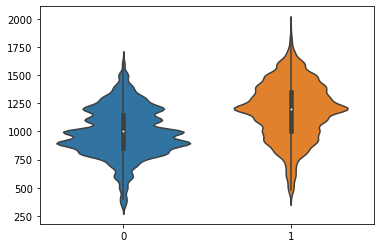

In [65]:
ax = sns.violinplot(data=[all_papers[:,0], all_papers[:, 1]])

In [66]:
print(len(full_papers), len(all_papers))

31058 31058


In [67]:
for i in range(len(full_papers)):
    full_papers[i]["temp_time_vector"] = all_papers[i][:8]

In [69]:
if corpus_to_extract == 1:
    with open('data/ss_extracted_NO_IMPUTATION_precs_all_targets.pkl', 'wb') as f:
        pkl.dump(full_papers, f)
else:
    with open('data/sg_extracted_NO_IMPUTATION_precs_all_targets.pkl', 'wb') as f:
        pkl.dump(full_papers, f)